# Resonance 1 fr and 1/Qi vs T

In [51]:
# Example usage
from iminuit.cost import LeastSquares
from FitAPI import Fitter, Model
import numpy as np
import numpy as np
import sys
sys.path.append('../Graphics')
from Graphs import fitPlotter
import matplotlib.pyplot as plt

def S21_model(f: np.ndarray, f0: float, phi: float, Qt: float, Qc: float, A: float, B: float, C: float, D: float, K: float) -> np.ndarray:
    return (A + B*(f-fmin) + C*(f-fmin)**2 + D*(f-fmin)**3) + K * np.abs((1 - (Qt/np.abs(Qc))*np.exp(1j*phi)/(1 + 2j*Qt*((f-fmin) - f0)/fmin)))

# Estimate the initial guess of Qt
def peak_width(datax, datay):
    half_height_value = np.min(datay) + (np.max(datay) - np.min(datay)) / np.sqrt(2)
    hits = []
    above = datay[0] > half_height_value
    for i in range(1, len(datay)):
        new_above = datay[i] > half_height_value
        if new_above != above: 
            hits.append((datax[i] + datax[i-1]) / 2)
            above = new_above
    return abs(hits[-1] - hits[0])

result_fr = []
err_fr = []
result_Qi = []
err_Qi = []
T = []

f = []
y = []
for i in range(40, 116, 2):
    path = '../Data/fit_test/gap run12/Q_res' +str(i) +'.txt'
    data = np.loadtxt(path, delimiter=',', skiprows=0)
    f.append(data[:,0])
    I = data[:,1]
    Q = data[:,2]
    # Convert to module
    y.append(np.sqrt(I**2 + Q**2))
    T.append(410 - 10*((i-40)/2))

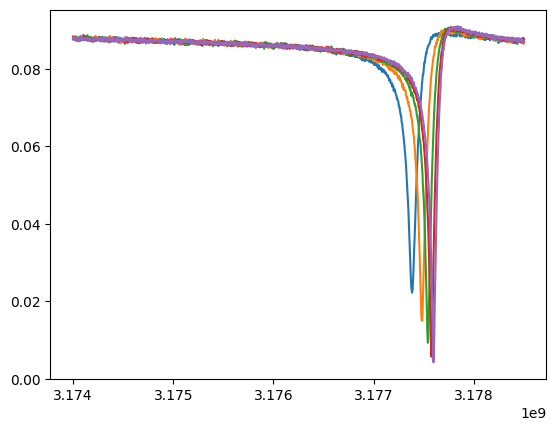

In [52]:
for i in range(5):
    plt.plot(f[i*3], y[i*3])
plt.show()

67000.0
3177383000.0
Qt_guess: 47423.62686567164
Initial guess: {'f0': 17000, 'phi': -0.2369, 'Qc': 29208, 'A': 0.0, 'B': 2.8643e-08, 'C': 8.0398e-15, 'D': -3.5988e-20, 'Qt': np.float64(47423.62686567164), 'K': np.float64(0.0415335458519284)}
limit:  Qc (100.0, 10000000.0)
limit:  Qt (100.0, 10000000.0)
Q_res40
Q_i: 148786.46218340506
Result: {'f0': 13015.351662146957, 'phi': -0.16434712118752937, 'Qt': 19806.48979835649, 'Qc': 22848.024316299023, 'A': 0.011157331822215464, 'B': 1.2755680044984825e-08, 'C': -3.0081930043633793e-15, 'D': -5.2529291063887204e-20, 'K': 0.07614083284355393}
64500.0
3177414000.0
Qt_guess: 49262.232558139534
Initial guess: {'f0': 17000, 'phi': -0.2369, 'Qc': 29208, 'A': 0.0, 'B': 2.8643e-08, 'C': 8.0398e-15, 'D': -3.5988e-20, 'Qt': np.float64(49262.232558139534), 'K': np.float64(0.04142054612941411)}
limit:  Qc (100.0, 10000000.0)
limit:  Qt (100.0, 10000000.0)
Q_res42
Q_i: 183311.2626289323
Result: {'f0': 11738.503751067965, 'phi': -0.16675220509475075, 'Qt

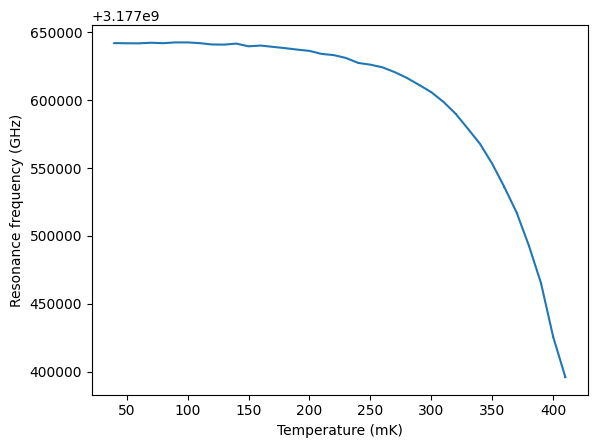

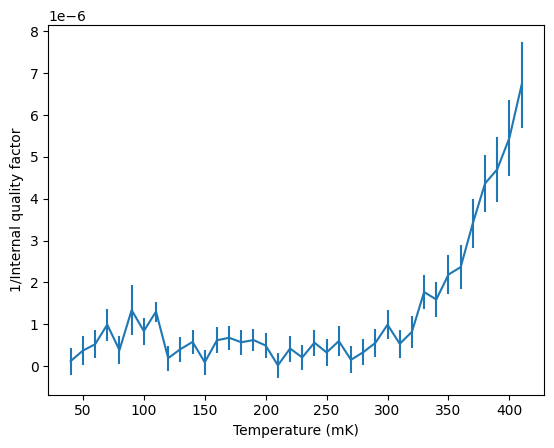

In [55]:
#empty result and err arrays
result_fr = []
err_fr = []
result_Qi = []
err_Qi = []

initial_guess = {
    "f0": 17000, #0.1,
    "phi": -0.2369, # 2.1,
    "Qc": 29208,
    "A": 0.0, #1.0,
    "B": 2.8643e-8 ,#1e-9,
    "C": 8.0398e-15,#1e-18,
    "D": -3.5988e-20, # 1e-27
    }

param_limits = {
    "Qc": (1e2, 1e7),
    "Qt": (1e2, 1e7),
    #'phi': (-20, 20),
    #'f0': (-1e6, 1e6),
    }

for i in range(0, len(T)):
    f_i = f[int(i)]
    y_i = y[int(i)]
    
    fmin = f_i[np.argmin(y_i)]
    fwhm = peak_width(f_i, -y_i)
    
    mask = (f_i > fmin - 7 * fwhm) & (f_i < fmin + 7 * fwhm)
    f_i = f_i[mask]
    y_i = y_i[mask]
    #plt.plot(f_i, y_i)
    #plt.show()
    # Estimate the initial guess of Qt
    Qt_guess = fmin / peak_width(f_i, -y_i)
    print(peak_width(f_i, -y_i))
    print(fmin)
    
    print(f"Qt_guess: {Qt_guess}")
    initial_guess['Qt'] = Qt_guess
    #initial_guess['Qt'] = 21983

    # Estimate the initial guess of K
    initial_guess['K'] = (np.max(y_i) - np.min(y_i)) * initial_guess['Qc'] / initial_guess['Qt']
    #initial_guess['K'] = 0.9623
    print(f"Initial guess: {initial_guess}")

    fit_data = np.column_stack((f_i, y_i))
    fitter = Fitter(model_function=S21_model, 
                    param_names=["f0", "phi", "Qt", "Qc", "A", "B", "C", "D", "K"], 
                    data=fit_data, 
                    loss_function=LeastSquares,
                    params_initial_guess=initial_guess,
                    params_range=param_limits)

    fitter.model.set_active_params(fitter.model.param_names)
    result = fitter.fit()
    result_dict = result.values.to_dict()
    err_dict = result.errors.to_dict()
    
    result_fr.append(result_dict['f0'] + fmin)
    err_fr.append(err_dict['f0'])
    
    result_Qi.append(abs((1/result_dict['Qt']-1/result_dict['Qc'])**-1))
    Qt = result_dict['Qt']
    Qc = result_dict['Qc']
    err_Qi.append(np.sqrt((err_dict['Qt'] * Qt**-2)**2 + (err_dict['Qc'] * Qc**-2)**2) * ((1/Qt-1/Qc)**-2))
    
    print("Q_res" + str(i*2 + 40))
    print("Q_i: " + str(abs((1/result_dict['Qt']-1/result_dict['Qc'])**-1)))
    
    print(f"Result: {result_dict}")
    # grapher = fitPlotter(result, f_i, y_i, S21_model)
    # grapher.simple_plot()
    
    
    
print(result_fr)
print(result_Qi)
print(T) 
#print lenght of every result and error array
print(len(result_fr))
print(len(err_fr))
print(len(result_Qi))
print(len(err_Qi))
print(len(T))

plt.errorbar(T, result_fr, err_fr, linestyle='-', label='fr')
plt.ylabel('Resonance frequency (GHz)')
plt.xlabel('Temperature (mK)')
plt.show()

Qi_plot = 1/np.array(result_Qi)
err_Qi_plot = err_Qi*np.array(result_Qi)**-2
i
plt.errorbar(T, Qi_plot, err_Qi_plot, linestyle='-', label='Qi')
plt.ylabel('1/Internal quality factor')
plt.xlabel('Temperature (mK)')
plt.show()




29208.338112823883
17000.0


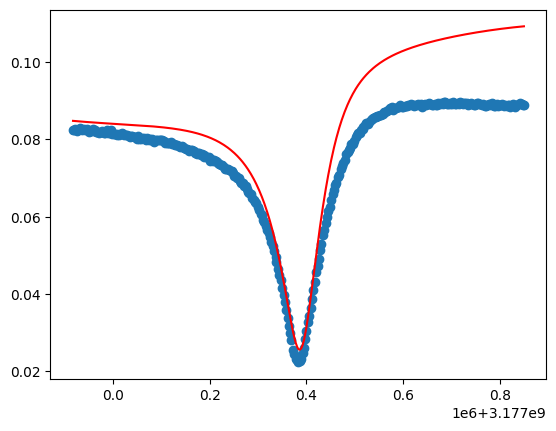

In [41]:
def S21__fixed_model(f: np.ndarray) -> np.ndarray:
    
    K = 0.09623
    Qt = 21983
    Qi = 88866
    Qc = 1/(1/Qt - 1/Qi)
    phi = -0.2369
    f0 = 3.1774e9 - fmin
    A = 0.0
    B = 2.8643e-8
    C = 8.0398e-15
    D = -3.5988e-20
    
    print(Qc)
    print(f0)
    
    return (A + B*(f-fmin) + C*(f-fmin)**2 + D*(f-fmin)**3) + K * np.abs((1 - Qt*np.abs(1/Qt - 1/Qi)*np.exp(1j*phi)/(1 + 2j*Qt*((f-fmin) - f0)/fmin)))

plt.scatter(f_i, y_i)
plt.plot(f_i, S21__fixed_model(f_i), color='red')
